In [1]:
from hybridbrep import HybridPart

In [2]:
import numpy as np
import meshplot as mp

In [3]:
part = HybridPart('../../datasets/cubes/angled_cube.x_t', 500, 5000, True)

In [75]:
from automate import HetData
from hybridbrep_cpp import HybridPart
from math import ceil, sqrt
import torch
import numpy as np
class HPart():
    def __init__(self, path, n_samples=500, n_ref_samples=5000, normalize=False):
        part = HybridPart(path, n_samples, n_ref_samples, normalize)
        data = HetData()
        ### Part Level Stats ###
        data.bounding_box = torch.tensor(part.bounding_box.reshape((1,2,3))).float()
        data.translation = torch.tensor(part.translation).float()
        data.scale = torch.tensor(part.scale).float()
        data.__node_sets__.add('bounding_box')
        data.__node_sets__.add('translation')
        data.__node_sets__.add('scale')
        
        ### Face Encodings ###
        # One-Hot Encode Surface Types -- Non-Simple are all 0s
        face_surfaces = torch.tensor(part.face_surfaces, dtype=int)
        face_surfaces = torch.nn.functional.one_hot(face_surfaces, max(5, face_surfaces.max())).float()
        face_surfaces = face_surfaces[:,:5]
        face_surface_parameters = torch.tensor(part.face_surface_parameters).float()
        face_surface_flipped = torch.tensor(part.face_surface_flipped).reshape((-1,1)).float()
        data.faces = torch.cat([face_surfaces, face_surface_parameters, face_surface_flipped],dim=1).float()
        data.__node_sets__.add('faces')

        ### Edge Encodings ###
        # One-Hot Encode Curve Types -- Nno-Simple are all 0s
        edge_curves = torch.tensor(part.edge_curves, dtype=int)
        edge_curves = torch.nn.functional.one_hot(edge_curves, max(3, edge_curves.max())).float()
        edge_curves = edge_curves[:,:3]
        edge_curve_parameters = torch.tensor(part.edge_curve_parameters).float()
        edge_curve_flipped = torch.tensor(part.edge_curve_flipped).reshape((-1,1)).float()
        data.edges = torch.cat([edge_curves, edge_curve_parameters, edge_curve_flipped],dim=1).float()
        data.__node_sets__.add('edges')

        ### Vertex Encodings ###
        data.vertices = torch.tensor(part.vertex_positions).float()
        data.__node_sets__.add('vertices')

        ### Relationships ###
        data.face_to_face = torch.tensor(part.face_to_face).long()
        data.edge_to_face = torch.tensor([part.face_to_edge[1], part.face_to_edge[0]]).long()
        data.edge_to_face_flipped = torch.tensor(part.face_to_edge_flipped).reshape((-1,1)).float()
        data.vertex_to_edge = torch.tensor([part.edge_to_vertex[1], part.edge_to_vertex[0]]).long()
        data.vertex_to_edge_is_start = torch.tensor(part.edge_to_vertex_is_start).reshape((-1,1)).float()
        data.__edge_sets__['face_to_face'] = ['faces', 'faces', 'edges']
        data.__edge_sets__['edge_to_face'] = ['edges', 'faces']
        data.__edge_sets__['vertex_to_edge'] = ['vertices', 'edges']
        data.__node_sets__.add('edge_to_face_flipped')
        data.__node_sets__.add('vertex_to_edge_is_start')


        ### Surface and Curve Samples ###
        curve_size = int(ceil(sqrt(n_samples)))

        data.surface_bounds = torch.tensor(np.stack(part.surface_bounds)).float() if len(part.surface_bounds) > 0 else torch.empty((0,2,2))
        data.surface_coords = torch.tensor(np.stack(part.surface_coords)).float() if len(part.surface_coords) > 0 else torch.empty((0,n_samples,2))
        
        data.surface_samples = torch.tensor(np.stack(part.surface_samples)).float() if len(part.surface_samples) > 0 else torch.empty((0,n_samples,7))
        data.curve_bounds = torch.tensor(np.stack(part.curve_bounds)).float() if len(part.curve_bounds) > 0 else torch.empty((0, 2)).float()
        data.curve_samples = torch.tensor(np.stack(part.curve_samples)).float() if len(part.curve_samples) > 0 else torch.empty((0,curve_size,6)).float()
        # Flip the curve samples to make edge samples
        # Masks and sums flipped and unflipped versions of every edge
        data.curve_samples = (
            data.curve_samples.flip(dims=(1,)).T * part.edge_curve_flipped + 
            data.curve_samples.T * (1-part.edge_curve_flipped)
        ).T.float()
        
        data.__node_sets__.add('surface_bounds')
        data.__node_sets__.add('surface_coords')
        data.__node_sets__.add('surface_samples')
        data.__node_sets__.add('curve_bounds')
        data.__node_sets__.add('curve_samples')

        self.data = data
    
    def transform(self, translation, scale):
        pass

    def augment(self):
        pass

    def to_brep(self):
        pass
    
#hp = HPart('../../datasets/cubes/angled_cube.x_t', normalize=True)
hp = HPart('../../datasets/frame_guide/fg1.x_t', n_samples=5000, normalize=True)

In [5]:
from torch_geometric.data import Batch

In [6]:
hpx = HybridPart('../../datasets/cubes/angled_cube.x_t',500,5000,False)
hps = HybridPart('../../datasets/cubes/angled_cube.step',500,5000,False)


In [7]:
# Candidate GCN Layers that support edge attributes and bipartite graphs
# We would also love to have some form of residual here if possible
from automate import BipartiteResMRConv
from torch_geometric.nn import (
    GATv2Conv, # Number of attention heads is likely important, lazy
    TransformerConv, # Number of attention heads likely important, lazy, can do weighted residual
    GINEConv, # No residual-like function
    GMMConv, # Guassion-Mixture Model (2016), lazy
    NNConv, # Provide your own NN as input, lazy
    CGConv, # Used for crystal graphs
    GENConv, # From follow-up to DeepGCNs - very general, and lazy
    GeneralConv # From Design Space for GNNs paper, lazy, can do attention w/ multiple heads
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ben/anaconda3/envs/hybridbrep/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name     | Type            | Params
---------------------------------------------
0 | edge_enc | GeneralConv     | 448   
1 | face_enc | GeneralConv     | 1.6 K 
2 | edge_dec | ImplicitDecoder | 4.5 M 
3 | face_dec | ImplicitDecoder | 4.5 M 
---------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.358    Total estimated model params size (MB)
/home/ben/anaconda3/envs/hybridbrep/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader,

Training: 0it [00:00, ?it/s]

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.032756…

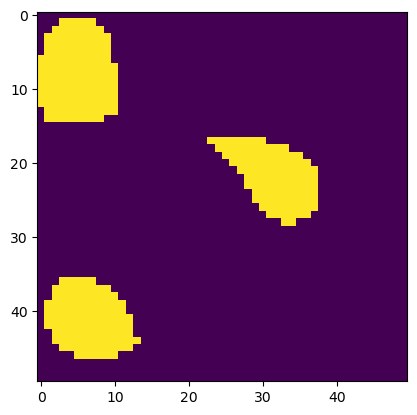

In [76]:
import os
import platform
if platform.system() == 'Linux' and 'microsoft' not in platform.release():
    os.environ['PYOPENGL_PLATFORM'] = 'egl'
import pyrender

import torch
import torch_geometric as tg
from pytorch_lightning import LightningModule
from hybridbrep import ImplicitDecoder

class HybridPredictor(LightningModule):
    def __init__(self):
        super().__init__()
        self.renderer = None

    def ensure_renderer(self):
        if self.renderer is None:
            self.renderer = pyrender.OffscreenRenderer(
                viewport_width=200,
                viewport_height=200,
                point_size=1.0
            )
        pass

    def destroy_renderer(self):
        if self.renderer is not None:
            self.renderer.delete()

    def forward(self, batch, face_coords, edge_coords=None):
        return self.model(batch, face_coords, edge_coords)

    def mesh_enc_dec(self, batch, n_samples, grid_bounds=(-.1,1.1)):
        face_codes = self.encode_faces(batch)
        edge_codes = self.encode_edges(batch)
        Vs, Fs = self.mesh_decode(face_codes, n_samples, edge_codes, grid_bounds)
        # TODO - label by originating part
        return Vs, Fs

    def mesh_decode(self, face_codes, n_samples=50, edge_codes=None, grid_bounds=(-.1,1.1)):
        decoded = self.grid_decode(face_codes, n_samples, edge_codes, grid_bounds)
        if edge_codes is None:
            face_preds = decoded
        else:
            face_preds, edge_preds = decoded
        Vs = None
        Fs = None
        # TODO - renumber by originating part if reasonable
        return Vs, Fs

    def grid_enc_dec(self, batch, n_samples=50, grid_bounds=(-.1,1.1)):
        face_codes = self.encode_faces(batch)
        edge_codes = self.encode_edges(batch)
        return self.grid_decode(face_codes, n_samples, edge_codes, grid_bounds)
    
    def grid_decode(self, face_codes, n_samples=50, edge_codes=None, grid_bounds=(-.1,1.1)):
        n_faces = face_codes.shape[0]
        face_u = torch.linspace(0, 1, n_samples)
        face_uv = torch.stack([torch.cartesian_prod(face_u, face_u)]*n_faces)
        #face_batch = torch.arange(n_faces).repeat_interleave(3)
        face_preds = self.decode_faces(face_codes, face_uv)
        if edge_codes is not None:
            n_edges = edge_codes.shape[0]
            edge_grid = torch.linspace(0.0,1.0,n_samples).repeat(n_edges,1)
            edge_preds = self.decode_edges(edge_codes, edge_grid)
            return face_preds, edge_preds
        else:
            return face_preds
        
        

    def eval_common(self, batch, batch_idx):
        # Edge Targets and coordinates
        n_curves, n_c_samples, c_sample_dim = batch.curve_samples.shape
        c_xyz = batch.curve_samples[:,:,:3].reshape((-1,3))
        edge_coords = torch.linspace(0.,1.,n_c_samples).repeat(n_curves).reshape((n_curves,-1))

        # Face Targets
        n_surfs, n_s_samples, s_sample_dim = batch.surface_samples.shape
        s_xyz = batch.surface_samples[:,:,:3].reshape((-1,3))
        s_m = batch.surface_samples[:,:,s_sample_dim-1].flatten()
        face_coords = batch.surface_coords

        _, face_preds, _, edge_preds = self(batch, face_coords, edge_coords)

        face_preds_xyz = face_preds[:,:3]
        face_preds_m = face_preds[:,3]

        edge_loss = torch.nn.functional.mse_loss(edge_preds, c_xyz)
        face_loss_xyz = torch.nn.functional.mse_loss(face_preds_xyz, s_xyz)
        face_loss_mask = ((face_preds_m - s_m)**2).mean()#torch.nn.functional.mse_loss(face_preds_m, s_m)

        loss = edge_loss + face_loss_xyz + face_loss_mask

        return loss, edge_loss, face_loss_xyz, face_loss_mask

    def training_step(self, batch, batch_idx):
        loss, edge_loss, face_loss_xyz, face_loss_mask = self.eval_common(batch, batch_idx)
        self.log('edge_loss', edge_loss)
        self.log('face_loss_xyz', face_loss_xyz)
        self.log('face_loss_mask', face_loss_mask)
        self.log('loss', loss)
        return face_loss_mask

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

class GeneralConvEncDec(HybridPredictor):
    def __init__(self, emb_dim=128, dec_dim=128, dec_layers=4):
        super().__init__()
        self.edge_enc = GeneralConv(-1,emb_dim,-1, attention=True, heads=2)
        self.face_enc = GeneralConv(-1,emb_dim,-1, attention=True, heads=8)
        self.edge_dec = ImplicitDecoder(emb_dim+1, 3, dec_dim, dec_layers, use_tanh=False)
        self.face_dec = ImplicitDecoder(emb_dim+2, 4, dec_dim, dec_layers, use_tanh=False)
    
    def encode_edges(self, batch):
        oh= torch.nn.functional.one_hot(torch.arange(len(batch.edges))).float()
        edge_codes = self.edge_enc((batch.vertices,batch.edges),batch.vertex_to_edge,None,batch.vertex_to_edge_is_start)
        edge_codes = torch.zeros_like(edge_codes)
        edge_codes[:,:oh.shape[1]] = oh
        return edge_codes.float()

    def encode_faces(self, batch, edge_codes=None):
        if edge_codes is None:
            edge_codes = self.encode_edges(batch)
        oh = torch.nn.functional.one_hot(torch.arange(len(batch.faces))).float()
        face_codes = self.face_enc((edge_codes, batch.faces),batch.edge_to_face,None,batch.edge_to_face_flipped)
        face_codes = torch.zeros_like(face_codes)
        face_codes[:,:oh.shape[1]] = oh
        return face_codes

    def decode_faces(self, face_codes, face_coords):
        n_surfs, n_s_samples, _ = face_coords.shape
        s_uv = face_coords.reshape((-1,2))
        rep_face_codes = face_codes.repeat_interleave(n_s_samples,dim=0)
        face_dec_input = torch.cat([s_uv, rep_face_codes],dim=1)
        return self.face_dec(face_dec_input)

    def enc_dec(self, batch, face_coords, edge_coords=None):
        edge_codes = self.encode_edges(batch)
        face_codes = self.encode_faces(batch, edge_codes)
        face_preds = self.decode_faces(face_codes, face_coords)
        if edge_coords is None:
            return face_codes, face_preds
        edge_preds = self.decode_edges(edge_codes, edge_coords)
        return face_codes, face_preds, edge_codes, edge_preds

    # edge_coords: [n_edges x n_edge_samples]
    def decode_edges(self, edge_codes, edge_coords):
        n_edges, n_c_samples = edge_coords.shape
        c_t = edge_coords.reshape((-1,1))
        rep_face_codes = edge_codes.repeat_interleave(n_c_samples,dim=0)
        face_dec_input = torch.cat([c_t, rep_face_codes],dim=1)
        return self.edge_dec(face_dec_input)

    def forward(self, batch, face_coords, edge_coords=None):
        return self.enc_dec(batch, face_coords, edge_coords)

import pytorch_lightning as pl

class FixedDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = hp.data
    def __getitem__(self, idx):
        return self.data
    def __len__(self):
        return 1


num_epochs = 200
dl = tg.loader.DataLoader(FixedDataset(), batch_size=1)
model = GeneralConvEncDec(emb_dim=64, dec_dim=1024, dec_layers=6)
#model.load_state_dict(sd)
#print(model.eval_common(next(iter(dl)),0))
trainer = pl.Trainer(max_epochs=num_epochs,log_every_n_steps=1)
trainer.fit(model,dl)
#print(model.eval_common(next(iter(dl)),0))

batch = next(iter(dl))
n_curves, n_c_samples, c_sample_dim = batch.curve_samples.shape
c_xyz = batch.curve_samples[:,:,:3].reshape((-1,3))
edge_coords = torch.linspace(0.,1.,n_c_samples).repeat(n_curves).reshape((n_curves,-1))

# Face Targets
n_surfs, n_s_samples, s_sample_dim = batch.surface_samples.shape
s_xyz = batch.surface_samples[:,:,:3].reshape((-1,3))
s_m = batch.surface_samples[:,:,s_sample_dim-1].flatten()
face_coords = batch.surface_coords

fc,fp,ec,ep = model(batch, face_coords, edge_coords)

gp = model.grid_enc_dec(next(iter(dl)),50)
fp,ep = gp
V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
points = fp[:,:3]
mask = fp[:,3]
m_points = points[mask <= 0]
plt.imshow((mask.reshape((-1,50,50)) <= 0)[11].detach().numpy())
#plot.add_points(points.detach().numpy(), c=(mask.detach().numpy() <= 0), shading={'point_color':'blue', 'point_size':0.15})

In [84]:
fc,fp,ec,ep = model(batch, face_coords, edge_coords)

In [ ]:
# Current problems are _both_ not enough sample density and not enough
# predictor resolution
# Proposed Solutions:
# - sample density - preferentially sample near boundaries
# - prediction resolution - try a siren-net or similar

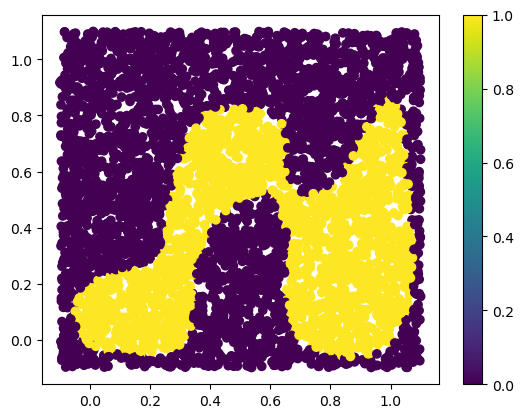

In [102]:
pred_mask = fp.reshape((-1,5000,4))[11][:,-1].detach().numpy()
plt.scatter(gt_u,gt_v,c=(pred_mask<=0.05))
plt.colorbar()

In [78]:
gt_u = batch.surface_coords[11][:,0].detach().numpy()
gt_v = batch.surface_coords[11][:,1].detach().numpy()
gt_mask = batch.surface_samples[11][:,-1].detach().numpy()

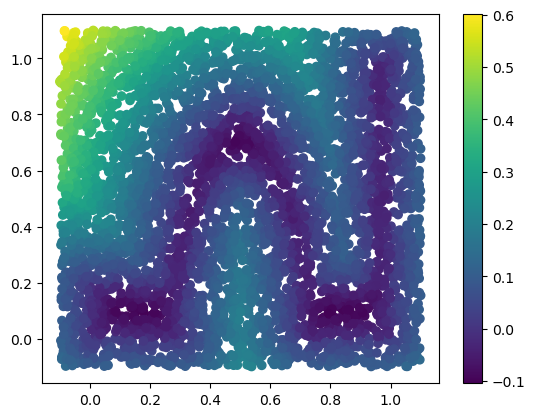

In [83]:
plt.scatter(gt_u,gt_v,c=gt_mask)
plt.colorbar()

In [77]:
V = batch.surface_samples[11,:,:3].reshape((-1,3))
mask = batch.surface_samples[11,:,-1].flatten()
V_m = V[mask <= 0].detach().numpy()
mp.plot(V.detach().numpy(),c=(mask.detach().numpy()<=0),shading={'point_size':0.4})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4974093…

In [65]:
gt_u.shape

(500,)

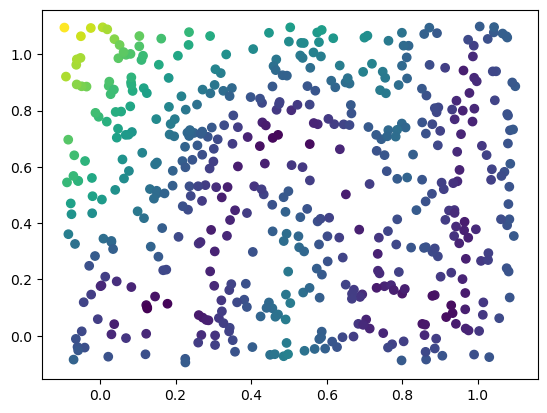

In [64]:
plt.scatter(gt_u, gt_v,c=gt_mask)

In [35]:
from matplotlib import pyplot as plt
from PIL import Image

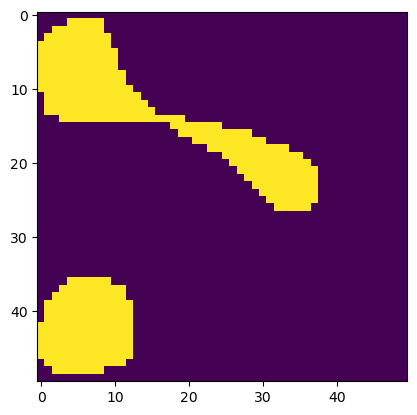

In [15]:
gp = model.grid_enc_dec(next(iter(dl)),50)
fp,ep = gp
V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
points = fp[:,:3]
mask = fp[:,3]
plot.add_points(points.detach().numpy(), c=(mask.detach().numpy() <= 0), shading={'point_color':'blue', 'point_size':0.15})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.7076730…

2

In [29]:
plot = mp.plot(ep.detach().numpy(), return_plot=True)
plot.add_points(V, shading={'point_color':'green'})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.006756…

1

In [20]:
fp[:,:3].min()

tensor(-0.2833, grad_fn=<MinBackward1>)

In [21]:
fp[:,:3].max()

tensor(0.2637, grad_fn=<MaxBackward1>)

In [26]:
batch.surface_samples[:,:,:3].max()

tensor(1.2129)

In [37]:
#gp = model.grid_enc_dec(next(iter(dl)),23)
#fp,ep = gp
fc,fp,ec,ep = model(batch, face_coords, edge_coords)

V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
V_f = batch.surface_samples[:,:,:3].reshape((-1,3)).numpy()
V_f = V_f[(batch.surface_samples[:,:,-1] <= 0).flatten().numpy()]
plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
plot.add_points(V_f, shading={'point_color':'blue', 'point_size':0.15})
#plot.add_points(fp[:,:3].detach().numpy(), shading={'point_color':'blue', 'point_size':0.15})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0051952…

2

In [13]:
batch.surface_samples[:,:,-1]

torch.Size([3174, 4])

In [49]:
# (d->h)*1, (d+h->h)*K, (d+h->o)*1

# ([dxh],[h]),  ([d+hxh],[h])*K, ([d+h x o], [o])

dim=1
hidden_dim=64
hidden_layers=4
out = 4

def lin_size(in_size, out_size):
    return in_size*out_size + out_size

def make_linear_layer(embedding, shape):
    (in_size, out_size) = shape
    weights = embedding[:in_size*out_size].reshape((in_size, out_size))
    biases = embedding[in_size*out_size,in_size*out_size+out_size]
    rest = embedding[in_size*out_size+out_size:]
    return (weights, biases, rest)

emb_size = (
    (dim*hidden_dim) + hidden_dim + # Input layer
    ( (dim+hidden_dim)*hidden_dim + hidden_dim)*(hidden_layers-1) + # Hidden Layers
    (dim+hidden_dim)*out + out # Output Layers
)




